In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import numpy as np
import cv2
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
resize = transforms.Resize((224, 224))
my_transform = transforms.Compose([resize, to_rgb, transforms.ToTensor(), normalize])
#my_transform = transforms.Compose([resize, to_rgb, transforms.ToTensor()])

In [3]:
train_data = dataset.MNIST(root='data/', train=True, transform=my_transform, download=True)
test_data  = dataset.MNIST(root='data/', train=False, transform=my_transform, download=True)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)
#print('number of training data: ', len(train_data))
#print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


In [0]:
#image, label = train_data[1]

#print('Image')
#print('========================================')
#print('shape of this image\t:', image.shape)
#print('7\'th row of this image\t:', image[1][6])

#print('Label')
#print('========================================')
#print('label: ', label)

Image
shape of this image	: torch.Size([3, 224, 224])
7'th row of this image	: tensor([-2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357, -2.0357,
        -2.0357, -2.0357, -2.0357, -2.035

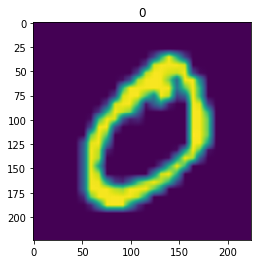

In [0]:
#plt.imshow(image[1])
#plt.imshow(image.squeeze().numpy(), cmap='gray')
#plt.title('%i' % label)
#plt.show()

In [0]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.beforeResidual = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.shortcut = nn.Conv2d(64, 512, kernel_size=2, stride=20, padding=5)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        #print(x.shape)
        x = self.beforeResidual(x)
        residual = x
        residual = self.shortcut(residual)
        # 64 channel, 112*112 size
        #print(x.shape)
        x = self.features(x)
        #print(x.shape)
        x = self.avgpool(x)
        #print(x.shape)
        x = torch.flatten(x, 1)  + torch.flatten(residual, 1)# x_1 dimension 맞추고 여기에 더해주기
        #print(x.shape)
        # 512 channel, 7*7 size
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 64
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg16(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)

vgg = vgg16(pretrained=False, progress=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)

In [7]:
#from torchsummary import summary
#summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4            [-1, 512, 7, 7]         131,584
            Conv2d-5        [-1, 128, 112, 112]          73,856
              ReLU-6        [-1, 128, 112, 112]               0
            Conv2d-7        [-1, 128, 112, 112]         147,584
              ReLU-8        [-1, 128, 112, 112]               0
         MaxPool2d-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 256, 56, 56]         295,168
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

In [0]:
classes =  ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(vgg.parameters(),lr=0.001)

In [9]:
if __name__=="__main__":
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            #print("count: " )
            #print(i)
            # zero the parameter gradients
            optimizer.zero_grad()

            #print(inputs.shape)  
            # forward + backward + optimize
            #print(vgg(inputs).shape)
            outputs = vgg(inputs)
            #print(outputs.shape)
            #print(outputs.shape)
            #print(labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if(loss.item() > 1000):
                print(loss.item())
                for param in vgg.parameters():
                    print(param.data)
            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
    print('Finished Training')

[1,    50] loss: 6.820
[1,   100] loss: 0.720
[1,   150] loss: 0.326
[1,   200] loss: 0.208
[1,   250] loss: 0.175
[1,   300] loss: 0.214
[1,   350] loss: 0.146
[1,   400] loss: 0.116
[1,   450] loss: 0.095
[1,   500] loss: 0.107
[1,   550] loss: 0.098
[1,   600] loss: 0.088


KeyboardInterrupt: ignored

In [10]:
if __name__=="__main__":
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    correct_total = 0
    count_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = vgg(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(100):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        count_total += class_total[i]
        correct_total += class_correct[i]
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    print('Overall Accuracy : %2d %%' % (
            100 * correct_total / count_total))

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 96 %
Accuracy of     7 : 96 %
Accuracy of     8 : 95 %
Accuracy of     9 : 97 %
Overall Accuracy : 97 %


In [0]:
#torch.save(vgg.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/prography-6th-deep-jonghakim/model.pth')

In [13]:
#from google.colab import auth
#auth.authenticate_user()

#from google.colab import drive
#drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
#!cat '/content/gdrive/Colab Notebooks/prography-6th-deep-jonghakim/VGG16-codes.ipynb'

cat: '/content/gdrive/Colab Notebooks/prography-6th-deep-jonghakim/VGG16-codes.ipynb': No such file or directory
